In [44]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

In [45]:
# Convert data to sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [46]:
# Load the dataset
df = pd.read_csv('../hardware_monitor_data.csv')
df = df.drop(['cpu_temperature', 'cpu_power'], axis='columns')

SEQ_LENGTH = 150
cpu_load = df['cpu_load'].values
sequences = create_sequences(cpu_load, SEQ_LENGTH)

# Split into train and test sets
train_data, test_data = train_test_split(sequences, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

In [ ]:
# Initialize the model
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1
NUM_LAYERS = 1

model = RNNModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
EPOCHS = 15
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch+1}/{EPOCHS}]") as progress_bar:
        for batch in progress_bar:
            inputs = batch[:, :-1].unsqueeze(-1)  # Input sequences
            targets = batch[:, -1].unsqueeze(-1)  # Target values

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=(epoch_loss / len(train_loader)))

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss / len(train_loader):.4f}")
torch.save(model,'./rnn_cpu_loadt.pth')

Epoch [1/15]: 100%|██████████| 899/899 [00:13<00:00, 66.65batch/s, loss=0.00363]


Epoch [1/15], Loss: 0.0036


Epoch [2/15]: 100%|██████████| 899/899 [00:13<00:00, 68.41batch/s, loss=0.00101] 


Epoch [2/15], Loss: 0.0010


Epoch [3/15]: 100%|██████████| 899/899 [00:13<00:00, 68.81batch/s, loss=0.000882]


Epoch [3/15], Loss: 0.0009


Epoch [4/15]: 100%|██████████| 899/899 [00:13<00:00, 68.82batch/s, loss=0.000864]


Epoch [4/15], Loss: 0.0009


Epoch [5/15]: 100%|██████████| 899/899 [00:15<00:00, 57.08batch/s, loss=0.000864]


Epoch [5/15], Loss: 0.0009


Epoch [6/15]: 100%|██████████| 899/899 [00:17<00:00, 50.26batch/s, loss=0.00102] 


Epoch [6/15], Loss: 0.0010


Epoch [7/15]: 100%|██████████| 899/899 [00:13<00:00, 68.28batch/s, loss=0.000893]


Epoch [7/15], Loss: 0.0009


Epoch [8/15]: 100%|██████████| 899/899 [00:13<00:00, 69.07batch/s, loss=0.00088] 


Epoch [8/15], Loss: 0.0009


Epoch [9/15]: 100%|██████████| 899/899 [00:13<00:00, 68.03batch/s, loss=0.000871]


Epoch [9/15], Loss: 0.0009


Epoch [10/15]: 100%|██████████| 899/899 [00:13<00:00, 68.47batch/s, loss=0.000878]


Epoch [10/15], Loss: 0.0009


Epoch [11/15]: 100%|██████████| 899/899 [00:13<00:00, 67.53batch/s, loss=0.000876]


Epoch [11/15], Loss: 0.0009


Epoch [12/15]: 100%|██████████| 899/899 [00:13<00:00, 68.69batch/s, loss=0.000859]


Epoch [12/15], Loss: 0.0009


Epoch [13/15]: 100%|██████████| 899/899 [00:12<00:00, 69.16batch/s, loss=0.000864]


Epoch [13/15], Loss: 0.0009


Epoch [14/15]: 100%|██████████| 899/899 [00:12<00:00, 69.21batch/s, loss=0.000855]


Epoch [14/15], Loss: 0.0009


Epoch [15/15]: 100%|██████████| 899/899 [00:13<00:00, 68.73batch/s, loss=0.000863]

Epoch [15/15], Loss: 0.0009


C:\Users\vishw\AppData\Local\Temp\ipykernel_18032\204701040.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./rnn_cpu_loadt.pth')


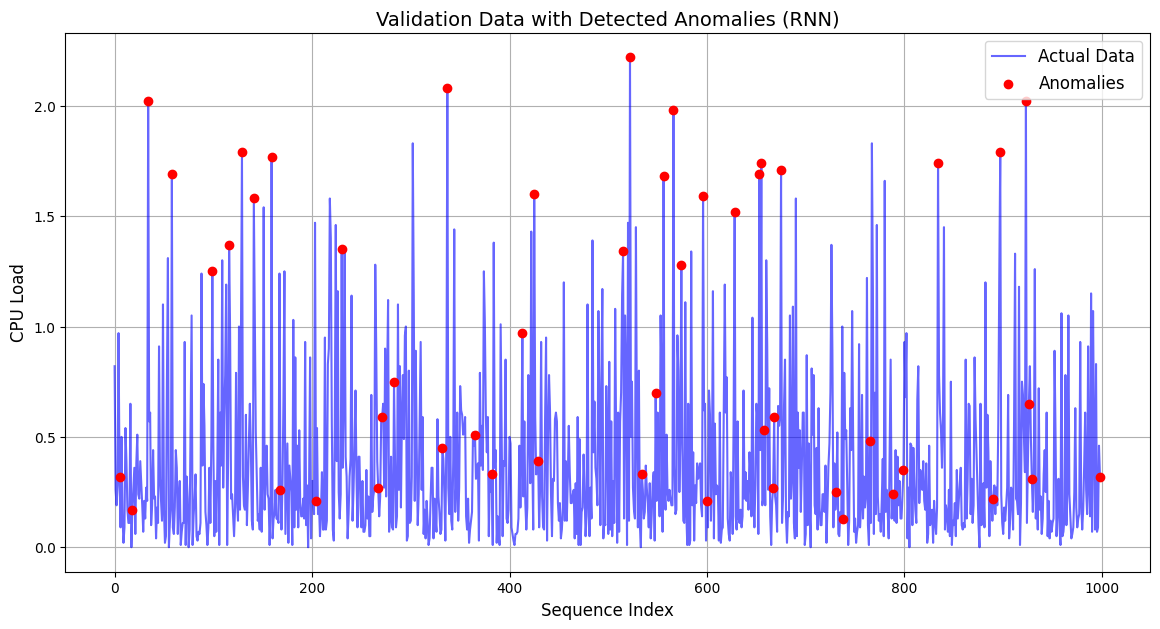

Threshold for anomalies: 0.008344390988349909
Number of anomalies detected: 50


In [72]:
import matplotlib.pyplot as plt
import torch 

model = torch.load('./rnn_cpu_loadt.pth')
model.eval()

test_inputs = test_data[1000:2000, :-1].unsqueeze(-1)  # Input sequences
test_targets = test_data[1000:2000, -1].unsqueeze(-1)  # True values for the last step

with torch.no_grad():
    predictions = model(test_inputs)

# Compute reconstruction error
reconstruction_error = torch.abs(predictions - test_targets).numpy()

# Set a threshold for anomalies
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

# Convert data to numpy for plotting
test_indices = np.arange(len(test_targets))
test_targets_np = test_targets.numpy().flatten()
predictions_np = predictions.numpy().flatten()

# Identify anomalies for plotting
anomaly_indices = test_indices[anomalies.flatten()]
anomaly_values = test_targets_np[anomalies.flatten()]

plt.figure(figsize=(14, 7))
# Plot actual data
plt.plot(test_indices, test_targets_np, label="Actual Data", color="blue", alpha=0.6)
# Highlight anomalies
plt.scatter(anomaly_indices, anomaly_values, color="red", label="Anomalies", zorder=3)
plt.title("Validation Data with Detected Anomalies (RNN)", fontsize=14)
plt.xlabel("Sequence Index", fontsize=12)
plt.ylabel("CPU Load", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


print(f"Threshold for anomalies: {threshold}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")


# Anomaly detection in memory usage

In [53]:
mem_usage = df['memory_usage'].values
mem_sequences = create_sequences(mem_usage, SEQ_LENGTH)

In [54]:
# Split into train and test sets
train_mem, test_mem = train_test_split(mem_sequences, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_mem = torch.FloatTensor(train_mem)
test_mem = torch.FloatTensor(test_mem)

In [ ]:
# Initialize the model
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1
NUM_LAYERS = 1

model = RNNModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
EPOCHS = 15
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(train_mem, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch+1}/{EPOCHS}]") as progress_bar:
        for batch in progress_bar:
            inputs = batch[:, :-1].unsqueeze(-1)  # Input sequences
            targets = batch[:, -1].unsqueeze(-1)  # Target values

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=(epoch_loss / len(train_loader)))

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss / len(train_loader):.4f}")
torch.save(model,'./rnn_mem_loadt.pth')

Epoch [1/15]: 100%|██████████| 899/899 [00:18<00:00, 48.08batch/s, loss=1.28e+3]


Epoch [1/15], Loss: 1283.0921


Epoch [2/15]: 100%|██████████| 899/899 [00:25<00:00, 34.80batch/s, loss=225] 


Epoch [2/15], Loss: 225.1552


Epoch [3/15]: 100%|██████████| 899/899 [00:25<00:00, 35.40batch/s, loss=190] 


Epoch [3/15], Loss: 190.0851


Epoch [4/15]: 100%|██████████| 899/899 [00:25<00:00, 35.95batch/s, loss=189] 


Epoch [4/15], Loss: 188.7406


Epoch [5/15]: 100%|██████████| 899/899 [00:25<00:00, 35.42batch/s, loss=188] 


Epoch [5/15], Loss: 188.2310


Epoch [6/15]: 100%|██████████| 899/899 [00:25<00:00, 35.37batch/s, loss=188] 


Epoch [6/15], Loss: 188.3472


Epoch [7/15]: 100%|██████████| 899/899 [00:25<00:00, 35.43batch/s, loss=188] 


Epoch [7/15], Loss: 187.6424


Epoch [8/15]: 100%|██████████| 899/899 [00:25<00:00, 35.31batch/s, loss=188] 


Epoch [8/15], Loss: 187.5506


Epoch [9/15]: 100%|██████████| 899/899 [00:25<00:00, 35.24batch/s, loss=187] 


Epoch [9/15], Loss: 186.9978


Epoch [10/15]: 100%|██████████| 899/899 [00:25<00:00, 35.80batch/s, loss=187] 


Epoch [10/15], Loss: 186.7293


Epoch [11/15]: 100%|██████████| 899/899 [00:26<00:00, 33.61batch/s, loss=187] 


Epoch [11/15], Loss: 187.0690


Epoch [12/15]: 100%|██████████| 899/899 [00:27<00:00, 33.27batch/s, loss=186] 


Epoch [12/15], Loss: 186.4895


Epoch [13/15]: 100%|██████████| 899/899 [00:25<00:00, 35.07batch/s, loss=187] 


Epoch [13/15], Loss: 186.7027


Epoch [14/15]: 100%|██████████| 899/899 [00:25<00:00, 35.60batch/s, loss=187] 


Epoch [14/15], Loss: 186.8520


Epoch [15/15]: 100%|██████████| 899/899 [00:32<00:00, 27.32batch/s, loss=187] 

Epoch [15/15], Loss: 186.5791


C:\Users\vishw\AppData\Local\Temp\ipykernel_18032\1764732616.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./rnn_mem_loadt.pth')


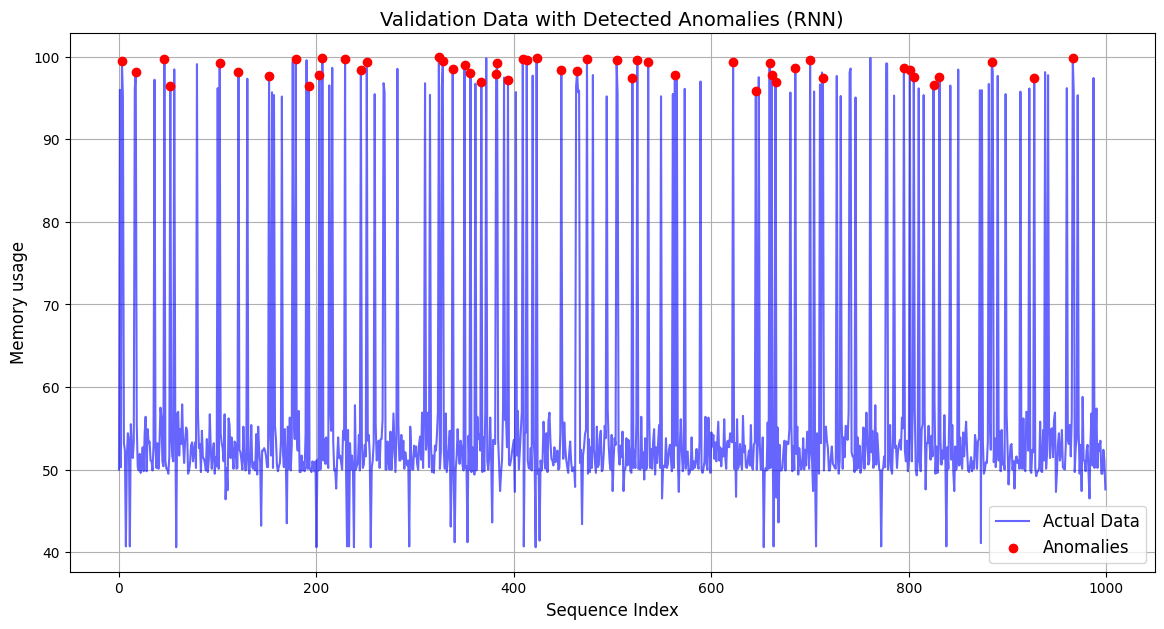

Threshold for anomalies: 40.545110321044916
Number of anomalies detected: 50


In [71]:
import matplotlib.pyplot as plt
import torch 

model = torch.load('./rnn_mem_loadt.pth')
model.eval()

test_inputs = test_mem[1000:2000, :-1].unsqueeze(-1)  # Input sequences
test_targets = test_mem[1000:2000, -1].unsqueeze(-1)  # True values for the last step

# Predictions
with torch.no_grad():
    predictions = model(test_inputs)

# Compute reconstruction error
reconstruction_error = torch.abs(predictions - test_targets).numpy()

# Set a threshold for anomalies
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

# Convert data to numpy for plotting
test_indices = np.arange(len(test_targets))
test_targets_np = test_targets.numpy().flatten()
predictions_np = predictions.numpy().flatten()

# Identify anomalies for plotting
anomaly_indices = test_indices[anomalies.flatten()]
anomaly_values = test_targets_np[anomalies.flatten()]

plt.figure(figsize=(14, 7))
# Plot actual data
plt.plot(test_indices, test_targets_np, label="Actual Data", color="blue", alpha=0.6)
# Highlight anomalies
plt.scatter(anomaly_indices, anomaly_values, color="red", label="Anomalies", zorder=3)
plt.title("Validation Data with Detected Anomalies (RNN)", fontsize=14)
plt.xlabel("Sequence Index", fontsize=12)
plt.ylabel("Memory usage", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


print(f"Threshold for anomalies: {threshold}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")


# Anomaly detection for CPU usage

In [63]:
cpu_usage = df['cpu_usage'].values
cpu_usage_sequences = create_sequences(cpu_usage, SEQ_LENGTH)

In [64]:
train_cpuu,test_cpuu = train_test_split(cpu_usage_sequences,test_size=0.2,random_state=42)

train_cpuu = torch.FloatTensor(train_cpuu)
test_cpuu = torch.FloatTensor(test_cpuu)

In [65]:
# Initialize the model
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1
NUM_LAYERS = 1

model = RNNModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
EPOCHS = 15
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(train_cpuu, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch+1}/{EPOCHS}]") as progress_bar:
        for batch in progress_bar:
            inputs = batch[:, :-1].unsqueeze(-1)  # Input sequences
            targets = batch[:, -1].unsqueeze(-1)  # Target values
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Update epoch loss
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=(epoch_loss / len(train_loader)))

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss / len(train_loader):.4f}")
torch.save(model,'./rnn_cpu_usaget.pth')

Epoch [1/15]: 100%|██████████| 899/899 [00:13<00:00, 65.44batch/s, loss=783] 


Epoch [1/15], Loss: 783.0586


Epoch [2/15]: 100%|██████████| 899/899 [00:13<00:00, 66.49batch/s, loss=774] 


Epoch [2/15], Loss: 774.0835


Epoch [3/15]: 100%|██████████| 899/899 [00:12<00:00, 69.67batch/s, loss=774] 


Epoch [3/15], Loss: 773.5156


Epoch [4/15]: 100%|██████████| 899/899 [00:12<00:00, 72.02batch/s, loss=773] 


Epoch [4/15], Loss: 773.4340


Epoch [5/15]: 100%|██████████| 899/899 [00:12<00:00, 71.12batch/s, loss=775] 


Epoch [5/15], Loss: 774.7390


Epoch [6/15]: 100%|██████████| 899/899 [00:13<00:00, 67.39batch/s, loss=774] 


Epoch [6/15], Loss: 774.1295


Epoch [7/15]: 100%|██████████| 899/899 [00:13<00:00, 68.84batch/s, loss=774] 


Epoch [7/15], Loss: 774.0379


Epoch [8/15]: 100%|██████████| 899/899 [00:13<00:00, 68.53batch/s, loss=773] 


Epoch [8/15], Loss: 773.0260


Epoch [9/15]: 100%|██████████| 899/899 [00:13<00:00, 68.68batch/s, loss=774] 


Epoch [9/15], Loss: 773.7666


Epoch [10/15]: 100%|██████████| 899/899 [00:13<00:00, 68.14batch/s, loss=773] 


Epoch [10/15], Loss: 773.1380


Epoch [11/15]: 100%|██████████| 899/899 [00:13<00:00, 68.38batch/s, loss=774] 


Epoch [11/15], Loss: 773.8538


Epoch [12/15]: 100%|██████████| 899/899 [00:13<00:00, 68.90batch/s, loss=773] 


Epoch [12/15], Loss: 773.0557


Epoch [13/15]: 100%|██████████| 899/899 [00:13<00:00, 68.79batch/s, loss=773] 


Epoch [13/15], Loss: 772.8242


Epoch [14/15]: 100%|██████████| 899/899 [00:12<00:00, 69.33batch/s, loss=774] 


Epoch [14/15], Loss: 773.8718


Epoch [15/15]: 100%|██████████| 899/899 [00:13<00:00, 66.41batch/s, loss=774] 

Epoch [15/15], Loss: 774.4434


C:\Users\vishw\AppData\Local\Temp\ipykernel_18032\198751441.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./rnn_cpu_usaget.pth')


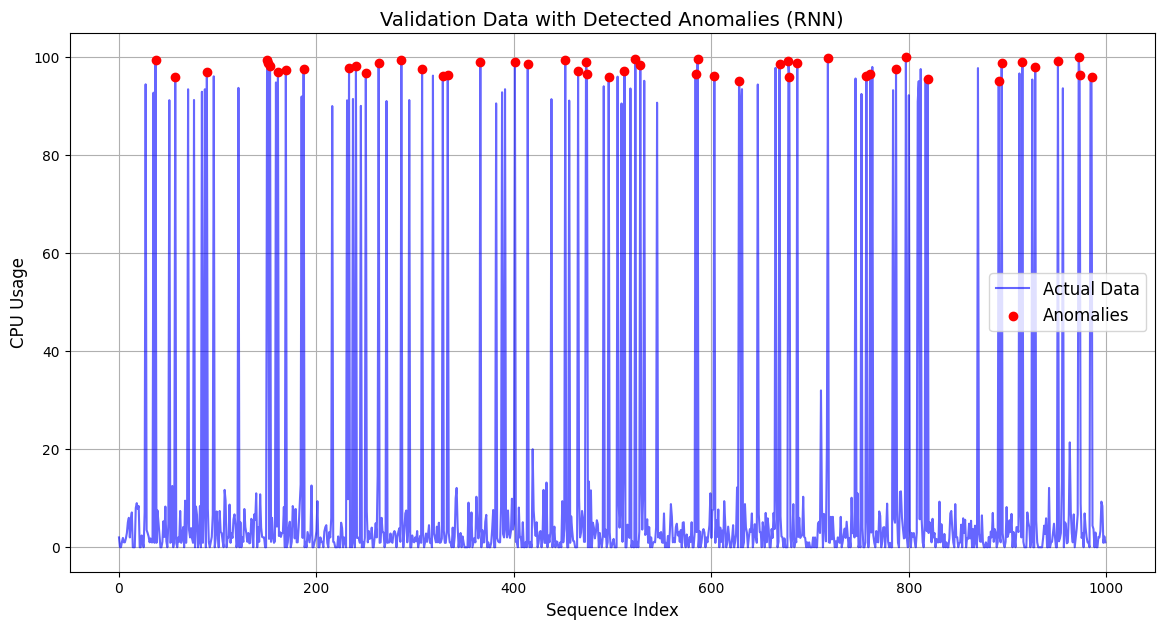

Threshold for anomalies: 84.31850318908691
Number of anomalies detected: 50


In [70]:
import matplotlib.pyplot as plt
import torch 

# Evaluate the model and detect anomalies
model = torch.load('./rnn_cpu_usaget.pth')
model.eval()

test_inputs = test_cpuu[1000:2000, :-1].unsqueeze(-1)  # Input sequences
test_targets = test_cpuu[1000:2000, -1].unsqueeze(-1)  # True values for the last step

with torch.no_grad():
    predictions = model(test_inputs)

# Compute reconstruction error
reconstruction_error = torch.abs(predictions - test_targets).numpy()

# Set a threshold for anomalies
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

# Convert data to numpy for plotting
test_indices = np.arange(len(test_targets))
test_targets_np = test_targets.numpy().flatten()
predictions_np = predictions.numpy().flatten()

# Identify anomalies for plotting
anomaly_indices = test_indices[anomalies.flatten()]
anomaly_values = test_targets_np[anomalies.flatten()]


plt.figure(figsize=(14, 7))
# Plot actual data
plt.plot(test_indices, test_targets_np, label="Actual Data", color="blue", alpha=0.6)
# Highlight anomalies
plt.scatter(anomaly_indices, anomaly_values, color="red", label="Anomalies", zorder=3)
plt.title("Validation Data with Detected Anomalies (RNN)", fontsize=14)
plt.xlabel("Sequence Index", fontsize=12)
plt.ylabel("CPU Usage", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Additional information
print(f"Threshold for anomalies: {threshold}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")
